In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import maxentep
# disabling gpu for now
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
EPS = np.finfo(np.float32).tiny
param_batch_size = 1024
maxent_batch_size = 32
sns.set_context('notebook')

## Set-up Starting Dist

In [2]:
M = 3
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.61118046, 0.32994634, 0.0588732 ],
        [0.01424449, 0.79935197, 0.18640354],
        [0.33323713, 0.22383911, 0.44292376]]),
 array([1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 2)
tmat.add_transition('A', 'I', 3, 1)
tmat.add_transition('I', 'R', 14, 3)

In [4]:
start_logits = np.ones((M,))

## Set-up unbiased Joint

In [5]:
unbiased_model = maxentep.ParameterJoint(start_logits, R, tmat, name='unbiased')
unbiased_joint = unbiased_model(tf.constant([1.]))
unbiased_joint

[<tfp.distributions.Independent 'unbiased_model_R_dist_dist_Independentunbiased_model_R_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3, 3] dtype=float32>,
 <tfp.distributions.JointDistributionSequentialAutoBatched 'unbiased_model_T_dist_dist_JointDistributionSequentialAutoBatched' batch_shape=[] event_shape=[[3], [4], [4, 4]] dtype=[float32, float32, float32]>,
 <tfp.distributions.JointDistributionSequential 'unbiased_model_rho_dist_dist_JointDistributionSequential' batch_shape=[[], [], []] event_shape=[[1, 3], [1], [1, 3]] dtype=[float32, float32, float32]>,
 <tfp.distributions.Independent 'unbiased_model_beta_dist_Independentunbiased_model_beta_dist_TruncatedNormal' batch_shape=[] event_shape=[1] dtype=float32>]

## Create Trainable Joint

In [6]:
model = maxentep.ParameterJoint(start_logits, R, tmat, name='param-model')

## Set-up loglikelihood

In [7]:
model.compile(tf.optimizers.Adam(1e-3))
model.summary()

Model: "param-model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 3, 3)      18          input_2[0][0]                    
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 3, 3)      0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 4, 4)      32          input_2[0][0]                    
__________________________________________________________________________________

## Test out the prior distributions

In [8]:
p = model(tf.constant([1.]))
p

[<tfp.distributions.Independent 'param_model_model_R_dist_dist_Independentparam_model_model_R_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3, 3] dtype=float32>,
 <tfp.distributions.JointDistributionSequentialAutoBatched 'param_model_model_T_dist_dist_JointDistributionSequentialAutoBatched' batch_shape=[] event_shape=[[3], [4], [4, 4]] dtype=[float32, float32, float32]>,
 <tfp.distributions.JointDistributionSequential 'param_model_model_rho_dist_dist_JointDistributionSequential' batch_shape=[[], [], []] event_shape=[[1, 3], [1], [1, 3]] dtype=[float32, float32, float32]>,
 <tfp.distributions.Independent 'param_model_model_beta_dist_Independentparam_model_model_beta_dist_TruncatedNormal' batch_shape=[] event_shape=[1] dtype=float32>]

In [9]:
p[1]

<tfp.distributions.JointDistributionSequentialAutoBatched 'param_model_model_T_dist_dist_JointDistributionSequentialAutoBatched' batch_shape=[] event_shape=[[3], [4], [4, 4]] dtype=[float32, float32, float32]>

In [10]:
p[1].sample(2)
p[1].log_prob(p[1].sample(2))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.2874928, 5.073744 ], dtype=float32)>

In [11]:
s = [x.sample(2) for x in p]
print(s)

[<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
array([[[0.40451425, 0.5590967 , 0.41793656],
        [0.5247653 , 0.27528867, 0.21591479],
        [0.28390393, 0.843972  , 0.41251755]],

       [[0.38446718, 0.1437556 , 0.37366197],
        [0.39690837, 0.31416473, 0.25430062],
        [0.2434479 , 0.30902222, 0.5256886 ]]], dtype=float32)>, [<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.16804405, 0.29737473, 0.07615854],
       [0.18548952, 0.21269   , 0.07574084]], dtype=float32)>, <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.83195597, 0.7026253 , 0.9238415 , 1.        ],
       [0.81451046, 0.78731   , 0.9242592 , 1.        ]], dtype=float32)>, <tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[0.83195597, 0.16804405, 0.        , 0.        ],
        [0.        , 0.7026253 , 0.29737473, 0.        ],
        [0.        , 0.        , 0.9238415 , 0.07615854],
        [0.        , 0.        , 0.        , 1.        ]],

       [[0.81451046, 0.185489

In [12]:
p[1].log_prob(s[1])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([6.4191103, 5.6214113], dtype=float32)>

In [13]:
p[1]

<tfp.distributions.JointDistributionSequentialAutoBatched 'param_model_model_T_dist_dist_JointDistributionSequentialAutoBatched' batch_shape=[] event_shape=[[3], [4], [4, 4]] dtype=[float32, float32, float32]>

In [14]:
[pi.log_prob(si) for pi, si in zip(p, s)]

[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.3916707, 4.0689197], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([6.4191103, 5.6214113], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.253183  , 0.20926416], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.3841343, 0.6015325], dtype=float32)>]

In [15]:
model.evaluate(tf.constant([1., 1.]), s)

AttributeError: in user code:

    c:\users\white\maxent\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 test_function  *
        return step_function(self, iterator)
    c:\users\white\maxent\lib\site-packages\tensorflow\python\keras\engine\training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\white\maxent\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\white\maxent\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\white\maxent\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\white\maxent\lib\site-packages\tensorflow\python\keras\engine\training.py:1208 run_step  **
        outputs = model.test_step(data)
    c:\users\white\maxent\lib\site-packages\tensorflow\python\keras\engine\training.py:1177 test_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    c:\users\white\maxent\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:202 __call__
        y_t, y_p, sw = match_dtype_and_rank(y_t, y_p, sw)
    c:\users\white\maxent\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:617 match_dtype_and_rank
        if ((y_t.dtype.is_floating and y_p.dtype.is_floating) or

    AttributeError: 'list' object has no attribute 'is_floating'


## Make some restraints

In [8]:
r1 = maxentep.Restraint(lambda x: x[...,25,0,2], 0.4, maxentep.EmptyPrior())
r2 = maxentep.Restraint(lambda x: x[...,50,0,2], 0.2, maxentep.EmptyPrior())

## Make Metapopulation Model

In [9]:
meta_model = maxentep.MetaModel(maxentep.contact_infection_func([1,2]), 150)

## Maxent Model

In [10]:
maxent_model = maxentep.MaxentModel([r1, r2])
maxent_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

## Visualize Unbiased

Text(0.5, 1.0, 'Unbiased Result')

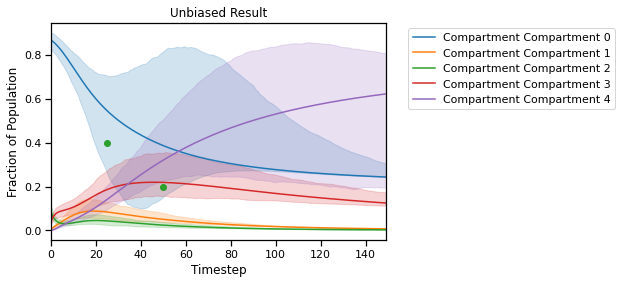

In [11]:
psample = [j.sample(param_batch_size) for j in unbiased_joint]
trajs = meta_model(*psample)
maxentep.traj_quantile(trajs[:,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Unbiased Result')

## Try to reweight without hyper-parameter tuning

In [12]:
me_loss = []
# sample and get batch
joint = model(tf.constant([0.]))
psample = [j.sample(param_batch_size) for j in joint]    
trajs = meta_model(*psample)
# get weights of trajectories
h = maxent_model.fit(trajs, batch_size=maxent_batch_size, epochs=128, verbose=False)
me_loss.extend(h.history['loss'])
w = maxent_model.traj_weights

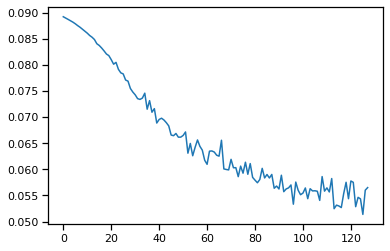

In [13]:
plt.plot(me_loss)
plt.show()

Text(0.5, 1.0, 'Maxent Result')

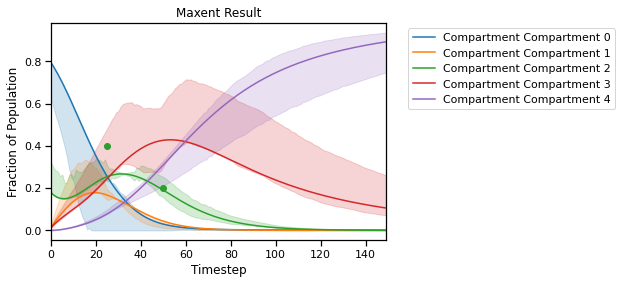

In [14]:
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result')

## Now tune hyperparameters at the same time

In [15]:
maxent_model = maxentep.HyperMaxentModel([r1, r2], model, meta_model)
maxent_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
maxent_model.fit(param_batch_size, 16, batch_size=32, epochs=8)

Epoch 1/8
32/32 [==============================] - 0s 683us/step - loss: 0.0783
Epoch 2/8
32/32 [==============================] - 0s 656us/step - loss: 0.0778
Epoch 3/8
32/32 [==============================] - 0s 656us/step - loss: 0.0773
Epoch 4/8
32/32 [==============================] - 0s 625us/step - loss: 0.0767
Epoch 5/8
32/32 [==============================] - 0s 631us/step - loss: 0.0764
Epoch 6/8
32/32 [==============================] - 0s 625us/step - loss: 0.0757
Epoch 7/8
32/32 [==============================] - 0s 625us/step - loss: 0.0749
Epoch 8/8
32/32 [==============================] - 0s 594us/step - loss: 0.0741
Epoch 1/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9417 - R-dist-dist_loss: -0.0476 - T-dist-dist_loss: -0.5762 - rho-dist-dist_loss: -0.2881 - beta-dist_loss: -0.0298
Epoch 2/8
32/32 [==============================] - 0s 3ms/step - loss: -0.9417 - R-dist-dist_loss: -0.0476 - T-dist-dist_loss: -0.5762 - rho-dist-dist_loss: -0.2881 - be

32/32 [==============================] - 0s 687us/step - loss: 0.0158
Epoch 8/8
32/32 [==============================] - 0s 656us/step - loss: 0.0188
Epoch 1/8
32/32 [==============================] - 0s 2ms/step - loss: -0.9421 - R-dist-dist_loss: -0.0476 - T-dist-dist_loss: -0.5764 - rho-dist-dist_loss: -0.2881 - beta-dist_loss: -0.0300
Epoch 2/8
32/32 [==============================] - 0s 2ms/step - loss: -0.9424 - R-dist-dist_loss: -0.0476 - T-dist-dist_loss: -0.5764 - rho-dist-dist_loss: -0.2881 - beta-dist_loss: -0.0303
Epoch 3/8
32/32 [==============================] - 0s 2ms/step - loss: -0.9425 - R-dist-dist_loss: -0.0476 - T-dist-dist_loss: -0.5764 - rho-dist-dist_loss: -0.2881 - beta-dist_loss: -0.0304
Epoch 4/8
32/32 [==============================] - 0s 2ms/step - loss: -0.9425 - R-dist-dist_loss: -0.0476 - T-dist-dist_loss: -0.5764 - rho-dist-dist_loss: -0.2881 - beta-dist_loss: -0.0304
Epoch 5/8
32/32 [==============================] - 0s 2ms/step - loss: -0.9425 - R-dis

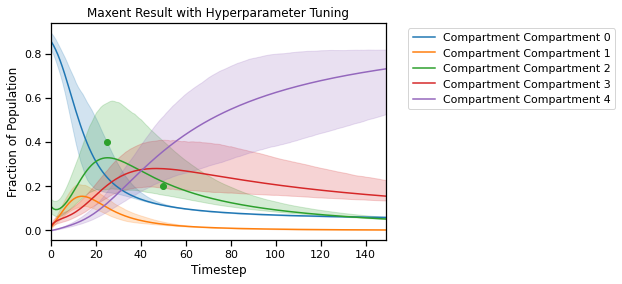

Text(0.5, 1.0, 'Maxent Result with Hyperparameter Tuning - Patch 2')

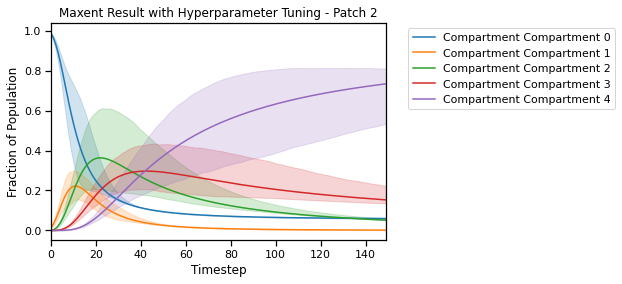

In [16]:
w = maxent_model.traj_weights
trajs = maxent_model.trajs
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result with Hyperparameter Tuning')
plt.show()

maxentep.traj_quantile(trajs[:,:,2,:], weights=w)
plt.title('Maxent Result with Hyperparameter Tuning - Patch 2')

## Now compare with Directed regression

In [17]:
infect = maxentep.ContactInfectionLayer(0.1, tmat.infectious_compartments)
reg_model = maxentep.TrainableMetaModel(start, R, tmat.value, infect, 100, lambda traj: (r1(traj)**2 + r2(traj)**2))

In [18]:
reg_model.compile(optimizer=tf.keras.optimizers.Adam(1e-2))
reg_model.fit(epochs=1, verbose=True)

100/100 [==============================] - 3s 33ms/step - loss: 0.0295 - output_2_loss: 0.0295


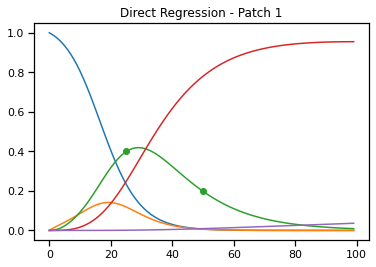

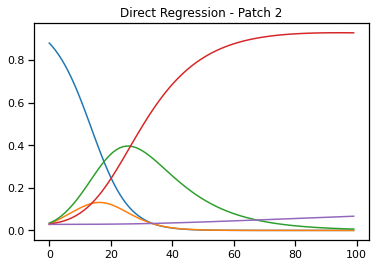

In [19]:
traj = reg_model.get_traj()
plt.plot(traj[0,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Direct Regression - Patch 1')
plt.show()
traj = reg_model.get_traj()
plt.plot(traj[0,:,1,:])
plt.title('Direct Regression - Patch 2')
plt.show()